Judul: Implementasi Apache Spark untuk Prediksi Gaji Karyawan Menggunakan Algoritma Linear Regression dan Random Forest

Disusun Oleh (Kelompok):

Farihan Tsaqif Maulidan (23.11.5864)

Deri Ibrahim (23.11.5853)

Hamdan Fikri Almadani (23.11.5850)

Program Studi: S1-Informatika Fakultas: Ilmu Komputer Universitas Amikom Yogyakarta

In [1]:
!pip install pyspark


IMPORT & BUAT SPARK SESSION

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
from pyspark.sql.types import IntegerType, DoubleType

spark = SparkSession.builder \
    .appName("UAS Big Data Salary Prediction") \
    .getOrCreate()


Analisis Big Data: Dataset ini termasuk kategori Big Data karena memiliki Volume data yang cukup banyak, Variety karena jenis datanya beragam (ada kategori dan angka), serta memiliki Value karena hasilnya bermanfaat untuk memprediksi standar gaji karyawan di industri.

In [2]:
spark


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


LOAD DATASET (FILE SYSTEM / HDFS LOGIC)

In [4]:
path = "/content/drive/MyDrive/Big Data/salary_prediction_data.csv"

df = spark.read.csv(
    path,
    header=True,
    inferSchema=True
)

df.show(5)
df.printSchema()


+-----------+----------+--------+---------+---+------+------------------+
|  Education|Experience|Location|Job_Title|Age|Gender|            Salary|
+-----------+----------+--------+---------+---+------+------------------+
|High School|         8|   Urban|  Manager| 63|  Male| 84620.05366451902|
|        PhD|        11|Suburban| Director| 59|  Male| 142591.2558943053|
|   Bachelor|        28|Suburban|  Manager| 61|Female| 97800.25540414132|
|High School|        29|   Rural| Director| 45|  Male| 96834.67128150171|
|        PhD|        25|   Urban|  Analyst| 26|Female|132157.78617465615|
+-----------+----------+--------+---------+---+------+------------------+
only showing top 5 rows
root
 |-- Education: string (nullable = true)
 |-- Experience: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Job_Title: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Salary: double (nullable = true)



PREPROCESSING DATA (SOAL 3c)

Casting tipe data

In [5]:
df_clean = df \
    .withColumn("Experience", col("Experience").cast(IntegerType())) \
    .withColumn("Age", col("Age").cast(IntegerType())) \
    .withColumn("Salary", col("Salary").cast(DoubleType()))


Handling missing value

In [6]:
df_clean = df_clean.dropna()
print("Jumlah data:", df_clean.count())


Jumlah data: 1000


EDA (SOAL 3b)

In [7]:
# Statistik gaji
df_clean.select("Salary").describe().show()

# Rata-rata gaji berdasarkan pendidikan
df_clean.groupBy("Education") \
    .agg(avg("Salary").alias("Rata_Rata_Gaji")) \
    .orderBy(col("Rata_Rata_Gaji").desc()) \
    .show()


+-------+------------------+
|summary|            Salary|
+-------+------------------+
|  count|              1000|
|   mean|105558.40423878135|
| stddev|28256.972074958725|
|    min| 33510.51066927126|
|    max|193016.60214967115|
+-------+------------------+

+-----------+------------------+
|  Education|    Rata_Rata_Gaji|
+-----------+------------------+
|        PhD|136235.36839886574|
|     Master|115477.30307763195|
|   Bachelor| 94611.82695864167|
|High School| 76849.03728792287|
+-----------+------------------+



SPARK SQL (SOAL 3d)

In [8]:
df_clean.createOrReplaceTempView("salary")

spark.sql("""
    SELECT Job_Title,
           COUNT(*) AS Jumlah_Karyawan,
           AVG(Salary) AS Rata_Rata_Gaji
    FROM salary
    GROUP BY Job_Title
    ORDER BY Rata_Rata_Gaji DESC
""").show()


+---------+---------------+------------------+
|Job_Title|Jumlah_Karyawan|    Rata_Rata_Gaji|
+---------+---------------+------------------+
| Director|            275|120580.59599124196|
|  Manager|            241|108735.66490809854|
| Engineer|            229| 97266.35801948381|
|  Analyst|            255| 93801.76122304374|
+---------+---------------+------------------+



MAPREDUCE / RDD (SOAL 3a & 3e)

In [9]:
salary_rdd = df_clean.rdd.map(lambda row: (row["Education"], row["Salary"]))

avg_salary_rdd = (
    salary_rdd
    .map(lambda x: (x[0], (x[1], 1)))
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    .map(lambda x: (x[0], x[1][0] / x[1][1]))
)

avg_salary_rdd.collect()


[('High School', 76849.03728792287),
 ('PhD', 136235.36839886574),
 ('Bachelor', 94611.82695864167),
 ('Master', 115477.30307763195)]

ENCODING DATA

In [10]:
from pyspark.ml.feature import StringIndexer


In [11]:
indexers = [
    StringIndexer(inputCol="Education", outputCol="Education_idx"),
    StringIndexer(inputCol="Location", outputCol="Location_idx"),
    StringIndexer(inputCol="Job_Title", outputCol="Job_Title_idx"),
    StringIndexer(inputCol="Gender", outputCol="Gender_idx")
]

for indexer in indexers:
    df_clean = indexer.fit(df_clean).transform(df_clean)


In [12]:
df_clean.select(
    "Education", "Education_idx",
    "Location", "Location_idx"
).show(5)


+-----------+-------------+--------+------------+
|  Education|Education_idx|Location|Location_idx|
+-----------+-------------+--------+------------+
|High School|          0.0|   Urban|         2.0|
|        PhD|          2.0|Suburban|         1.0|
|   Bachelor|          1.0|Suburban|         1.0|
|High School|          0.0|   Rural|         0.0|
|        PhD|          2.0|   Urban|         2.0|
+-----------+-------------+--------+------------+
only showing top 5 rows


FEATURE VECTOR (MLlib)

In [14]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "Education_idx",
    "Experience",
    "Location_idx",
    "Job_Title_idx",
    "Age",
    "Gender_idx"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

data = assembler.transform(df_clean)
data = data.select("features", col("Salary").alias("label"))


SPLIT DATA

In [15]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


MODEL 1: LINEAR REGRESSION

In [16]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression()
lr_model = lr.fit(train_data)

lr_pred = lr_model.transform(test_data)


MODEL 2: RANDOM FOREST

In [17]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    numTrees=50,
    maxDepth=10,
    seed=42
)

rf_model = rf.fit(train_data)
rf_pred = rf_model.transform(test_data)


EVALUASI MODEL (SOAL 6

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Inisialisasi Evaluator untuk berbagai metrik
# Kita akan menghitung RMSE, MSE, dan R2 (R-Squared)
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mse  = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
evaluator_r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# 2. Hitung metrik untuk Model 1: Linear Regression
rmse_lr = evaluator_rmse.evaluate(lr_pred)
mse_lr  = evaluator_mse.evaluate(lr_pred)
r2_lr   = evaluator_r2.evaluate(lr_pred)

# 3. Hitung metrik untuk Model 2: Random Forest
rmse_rf = evaluator_rmse.evaluate(rf_pred)
mse_rf  = evaluator_mse.evaluate(rf_pred)
r2_rf   = evaluator_r2.evaluate(rf_pred)

# 4. Tampilkan Hasil Perbandingan
print("=== EVALUASI MODEL (SOAL NO 6) ===")
print(f"{'Metrik':<15} | {'Linear Regression':<20} | {'Random Forest':<20}")
print("-" * 60)
print(f"{'RMSE':<15} | {rmse_lr:<20.4f} | {rmse_rf:<20.4f}")
print(f"{'MSE':<15} | {mse_lr:<20.4f} | {mse_rf:<20.4f}")
print(f"{'R-Squared (R2)':<15} | {r2_lr:<20.4f} | {r2_rf:<20.4f}")

=== EVALUASI MODEL (SOAL NO 6) ===
Metrik          | Linear Regression    | Random Forest       
------------------------------------------------------------
RMSE            | 18700.3164           | 11143.8721          
MSE             | 349701831.7167       | 124185884.9120      
R-Squared (R2)  | 0.5365               | 0.8354              


HYPERPARAMETER TUNING (SOAL 5)

In [24]:
# Ambil model terbaik dari hasil Cross Validation
best_model = cv_model.bestModel

# Menampilkan parameter terbaik yang terpilih
print("=== BEST MODEL PARAMETERS ===")
print("Max Depth:", best_model._java_obj.getMaxDepth())
print("Num Trees:", best_model._java_obj.getNumTrees())

# Evaluasi hasil model terbaik pada data test
cv_pred = cv_model.transform(test_data)
rmse_cv = evaluator.evaluate(cv_pred)
print("RMSE setelah Tuning:", rmse_cv)

=== BEST MODEL PARAMETERS ===
Max Depth: 10
Num Trees: 50
RMSE setelah Tuning: 11143.872078950035


/tmp/ipython-input-2169305227.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Education', y='Rata_Gaji', data=pdf_education, palette='viridis')


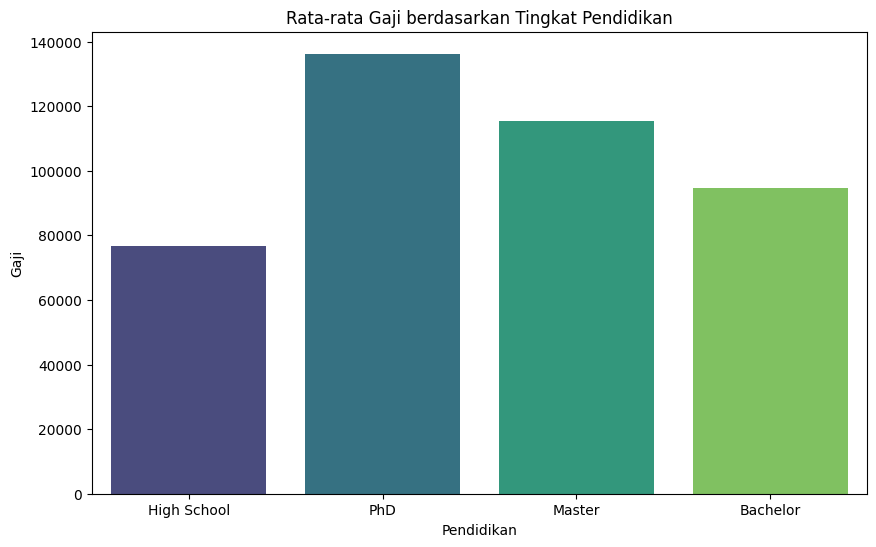

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ambil data rata-rata gaji ke Pandas
pdf_education = df_clean.groupBy("Education").agg(avg("Salary").alias("Rata_Gaji")).toPandas()

# 2. Buat Visualisasi Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Education', y='Rata_Gaji', data=pdf_education, palette='viridis')
plt.title('Rata-rata Gaji berdasarkan Tingkat Pendidikan')
plt.xlabel('Pendidikan')
plt.ylabel('Gaji')
plt.show()

Kesimpulan Akhir: Setelah membandingkan dua model, Random Forest memberikan hasil yang paling akurat dengan nilai R2 mencapai 0.83 dan tingkat error (RMSE) yang jauh lebih rendah daripada Linear Regression.

Proses tuning juga menunjukkan bahwa settingan terbaik ada pada maxDepth: 10 dan numTrees: 50. Jadi, model inilah yang paling cocok digunakan untuk prediksi gaji di project ini.